# Feature Extraction

## 1 Textbereinigung und Vorverarbeitung

Zusätzliche Stop-Words sollten hinzugefügt werden.
Stop Words müssen noch entfernt werden und gelemmat und gestemmt werden (Snowball stemmer), dass für jeden Text 
und dann müssen die Wörter wieder zusammengefügt werden zu dem Text, damit man danach noch N-Gramme bilden kann, 
um wenigstens ein bisschen Kontext erhalten zu lassen. Erstmal ohne POS-Tagging und NER.

Zuerst wird der Korpus eingelesen, um aus diesem geeignete Features zu generieren.

In [205]:
import pandas as pd

# Read csv file into dataframe
programs_df = pd.read_csv('election_programs.csv', encoding='utf-16')
programs_df

,party,path,text
0,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Bremen_20...,"\n\n3\n\nLiebe Bremerinnen und Bremer,\nliebe ..."
1,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NRW_2017.pdf,Landtagswahlprogramm 2017 Seite 0 von 54\n\nLa...
2,FDP,./Wahlprogramme/FDP/FDP_Grundsatzprogramm_2012...,Verantwortung für die Freiheit.\n Karlsr...
3,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NDS_2017.pdf,Wahlprogramm der Freien Demokraten\n z...
4,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Brandenbu...,BRANDENBURG\n WÄCHST MIT\n SEINEN\n MENSCHEN...
...,...,...,...
73,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,VOLLES\nPROGRAMM\n BERLIN\n STADT...
74,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,Wahlprogramm\n von BÜNDNIS 90/\nDIE GRÜN...
75,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,EIN N E U E S\n P I T E...
76,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Bundest...,ZUKUNFT\n WIRD\n AUS MUT\nGEMACHT.\n Bund...


In [206]:
print(programs_df['text'].apply(lambda x: len(x.split(' '))).sum())

5018476


Dann werden die einzelnen Dokumente des Korpus bereingt. Dazu wird mit jedem Text eine Vorverarbeitung
durchgeführt. **Diese dient dazu...**
Im Schritt der Vorverarbeitung werden folgende Aktionen durchgeführt:
1. Entfernen von Sonderzeichen ("\n", "\r", "    ") (müssen wir manuell machen, da SpaCy die bewusst drin lässt https://spacy.io/api/annotation)
2. Umwandlung in alles Kleinbuchstaben (damit Klein und klein dieselben Wörter sind. Wichtig für Wörter am Anfang eiens Satzes)
3. Entfernen von Satzzeichen und nicht alphanumerischen Zeichen (da diese keinen Einfluss haben sollen auf unsere Klassifizierung)
4. Stemming und Lemmatisierung (Lieber Lemma, da da richtige Worte rauskommen im Gegensatz zum Stemming)
5. Entfernen von Stop-Wörtern (da sie nichts über den Kontext des Textes aussagen)

Zur Beereinigung wird die Bibliothek SpaCy verwendet...

In [207]:
# Instanziieren von SpaCy für die deutsche Sprache
import spacy
nlp = spacy.load('de_core_news_sm')

# Definieren der Vorverarbeitungsfunktionen für einzelne Token
def preprocess_token(token):
    # Reduzierung von Token auf ihre kleingeschriebene lemmatisierte Form
    return token.lemma_.strip().lower()


# Überprüfung ob ein Token zulässig ist
# Es werden nur Token zugelassen, die keine Stop-Wörter, keine Satzzeichen oder nicht alphanumerische Zeichen sind
def is_token_allowed(token):
        if (not token or 
            token.is_stop or 
            token.is_punct or 
            not token.is_alpha):
            return False
        return True

In [208]:
# Über alle Reihen in dem DF iterieren und die Token durch die Funktionen schicken, und danach wieder joinen mit Leerzeichen.
# Das ist dann ein neuer Text und damit eine neue Spalte im DF.

def parseDocument(text):
    lowered_text = text.lower()
    document = nlp(lowered_text)
    allowed_token_list = [preprocess_token(token) for token in document if is_token_allowed(token)]
    parsed_text = " ".join(allowed_token_list)
    return parsed_text

programs_df["text_parsed"] = programs_df["text"].apply(parseDocument)

programs_df

,party,path,text,text_parsed
0,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Bremen_20...,"\n\n3\n\nLiebe Bremerinnen und Bremer,\nliebe ...",lieb bremerinnen bremer lieb bremerhavenerinne...
1,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NRW_2017.pdf,Landtagswahlprogramm 2017 Seite 0 von 54\n\nLa...,landtagswahlprogramm seite landtagswahlprogram...
2,FDP,./Wahlprogramme/FDP/FDP_Grundsatzprogramm_2012...,Verantwortung für die Freiheit.\n Karlsr...,verantwortung freiheit karlsruher karlsruher f...
3,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NDS_2017.pdf,Wahlprogramm der Freien Demokraten\n z...,wahlprogramm frei demokraten landtagswahl nied...
4,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Brandenbu...,BRANDENBURG\n WÄCHST MIT\n SEINEN\n MENSCHEN...,brandenburg wachsen wahlprogramm landtagswahl ...
...,...,...,...,...
73,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,VOLLES\nPROGRAMM\n BERLIN\n STADT...,voll programm berlin stadt möglichkeiten ideen...
74,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,Wahlprogramm\n von BÜNDNIS 90/\nDIE GRÜN...,wahlprogramm bündnis grün thüringen landtagswa...
75,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,EIN N E U E S\n P I T E...,n e u e s p i t e l g r u n k m w h l p ro gra...
76,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Bundest...,ZUKUNFT\n WIRD\n AUS MUT\nGEMACHT.\n Bund...,zukunft mut bundestagswahlprogramm bundestagsw...


In [209]:
print(programs_df['text_parsed'].apply(lambda x: len(x.split(' '))).sum())

1151079


## 2 Kodierung der Labels

bla bla, warum wir das machen..., weil Modelle oft einen numerischen Wert haben wollen. Keine Probleme mit Strings und Sonderzeichen(ü), Leerzeichen, etc...

In [210]:
party_codes = {
    'FDP': 0,
    'CDU': 1,
    'AfD': 2,
    'SPD': 3,
    'Die Grünen': 4,
    'Die Linke': 5
}

# Mapping der Parteinamen auf die Codes

programs_df['party_code'] = programs_df['party']
programs_df = programs_df.replace({'party_code':party_codes})
programs_df

,party,path,text,text_parsed,party_code
0,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Bremen_20...,"\n\n3\n\nLiebe Bremerinnen und Bremer,\nliebe ...",lieb bremerinnen bremer lieb bremerhavenerinne...,0
1,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NRW_2017.pdf,Landtagswahlprogramm 2017 Seite 0 von 54\n\nLa...,landtagswahlprogramm seite landtagswahlprogram...,0
2,FDP,./Wahlprogramme/FDP/FDP_Grundsatzprogramm_2012...,Verantwortung für die Freiheit.\n Karlsr...,verantwortung freiheit karlsruher karlsruher f...,0
3,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_NDS_2017.pdf,Wahlprogramm der Freien Demokraten\n z...,wahlprogramm frei demokraten landtagswahl nied...,0
4,FDP,./Wahlprogramme/FDP/FDP_Wahlprogramm_Brandenbu...,BRANDENBURG\n WÄCHST MIT\n SEINEN\n MENSCHEN...,brandenburg wachsen wahlprogramm landtagswahl ...,0
...,...,...,...,...,...
73,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,VOLLES\nPROGRAMM\n BERLIN\n STADT...,voll programm berlin stadt möglichkeiten ideen...,4
74,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,Wahlprogramm\n von BÜNDNIS 90/\nDIE GRÜN...,wahlprogramm bündnis grün thüringen landtagswa...,4
75,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Wahlpro...,EIN N E U E S\n P I T E...,n e u e s p i t e l g r u n k m w h l p ro gra...,4
76,Die Grünen,./Wahlprogramme/Die Grünen/Die_Grünen_Bundest...,ZUKUNFT\n WIRD\n AUS MUT\nGEMACHT.\n Bund...,zukunft mut bundestagswahlprogramm bundestagsw...,4


## 3 Aufteilung in Train- und Testdaten

Wir haben nicht viele Daten, lohnt das dann überhaupt? Müsste man mal prüfen und auf jeden Fall noch ganz viele Texte mehr raus suchen.

Um die Qualität der zu entwickelnden Modelle zu überprüfen, werden der Datensatz in Trainings- und Testdaten unterteilt. Mittels Cross-Validation werden die Hyperparameter der Modelle auf Bassis der Trainingsdaten abgestimmt. Die leistung der Modelle wir mittels der Testdaten geprüft.

Da der Korpus nicht besonders groß ist (... Dokumente) wird die Größe des Testdatensatzes nur 15% betragen.

In [211]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(programs_df['text_parsed'], 
                                                    programs_df['party_code'], 
                                                    test_size=0.2, 
                                                    random_state=123)

## 4 Text-Repräsentation

Es gibt diverse Möglichkeiten Texte als Features zu repräsentieren. Beispiel: (**Quelle**)
1. Count Vectors as features
2. TF-IDF Vectors als Features
3. Word Embeddings als Features
4. Text / NLP basierte Features
5. Topic Models als Features

In [212]:
# Count Vectors als Features Test
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(programs_df['text_parsed'].tolist())

word_vec_df = pd.DataFrame(X_counts.toarray(), columns= vectorizer.get_feature_names())
count_vec_df = pd.concat([programs_df['party'], word_vec_df], axis=1, sort=False)
count_vec_df

,party,aachen,aal,aalbestände,aalen,aartalbahn,aas,aav,aaüg,abarbeiten,...,übungsphasen,übungsraumangebote,übungsstunden,übungstrainer,übungszeiten,ück,ür,žylow,ﬂächendeckend,ﬂächendeckende
0,FDP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FDP,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FDP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,FDP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FDP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Die Grünen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
74,Die Grünen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,Die Grünen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
76,Die Grünen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Welches sind die am häufigsten vorkommenden Wörter über alle Dokumente gesehen?

In [213]:
word_sum_vec = count_vec_df.sum(axis = 0, skipna = True, numeric_only=True).sort_values(axis=0, ascending=False, inplace=False).head(15)
word_sum_vec

setzen          5355
stärken         4715
mein            4210
unterstützen    4203
land            4015
fördern         3758
öffentlich      3685
schaffen        3648
schulen         3425
wichtig         3378
stehen          3205
stark           3154
grün            3024
bildung         2846
stellen         2765
dtype: int64

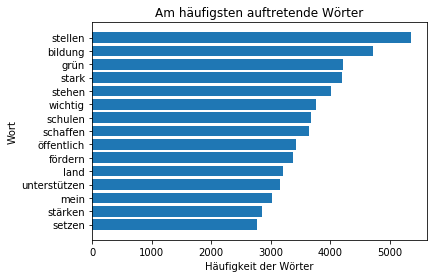

In [214]:
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(len(word_sum_vec))

plt.barh(index, word_sum_vec[::-1])
plt.yticks(index, word_sum_vec.index)
plt.ylabel('Wort')
plt.xlabel('Häufigkeit der Wörter')
plt.title('Am häufigsten auftretende Wörter')

plt.show()

In dieser Arbeit werden TF-IDF-Vektoren genutzt. **Warum und was ist das...**

**We have to define the different parameters:
ngram_range: We want to consider both unigrams and bigrams.
max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
See TfidfVectorizer? for further detail.
It needs to be mentioned that we are implicitly scaling our data when representing it as TF-IDF features with the argument norm.
Please note that we are fitting and then transforming the training set, but we are only transforming the test set.**

In [215]:
# Initialisierung der Parameter
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 1000

In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(encoding='utf-16',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

features_train = tfidf_vec.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf_vec.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(62, 1000)
(16, 1000)


**We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:**

In [217]:
from sklearn.feature_selection import chi2

for party, party_id in sorted(party_codes.items()):
    features_chi2 = chi2(features_train, labels_train == party_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' party:".format(party))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")


# 'AfD' party:
  . Most correlated unigrams:
. studierend
. einwanderung
. landesverband
. wahlprogramm
. afd
  . Most correlated bigrams:
. afd setzen
. afd fordern

# 'CDU' party:
  . Most correlated unigrams:
. april
. afd
. vorne
. regierungsprogramm
. cdu
  . Most correlated bigrams:
. alternative deutschland
. afd fordern

# 'Die Grünen' party:
  . Most correlated unigrams:
. grün
. geflüchteten
. grüne
. geflüchtete
. bündnis
  . Most correlated bigrams:
. afd setzen
. afd fordern

# 'Die Linke' party:
  . Most correlated unigrams:
. armut
. brandenburg
. geflüchtete
. solidarisch
. link
  . Most correlated bigrams:
. afd setzen
. afd fordern

# 'FDP' party:
  . Most correlated unigrams:
. afd
. liberal
. fdp
. liberale
. demokraten
  . Most correlated bigrams:
. frei demokraten
. freie demokraten

# 'SPD' party:
  . Most correlated unigrams:
. kita
. fortsetzen
. gewerkschaften
. afd
. spd
  . Most correlated bigrams:
. alternative deutschland
. afd fordern



In [218]:
print(len(bigrams))
bigrams

26


['milliarden euro',
 'europäisch union',
 'verfügung stellen',
 'beruflich bildung',
 'öffentlich hand',
 'ländlich raum',
 'mein landes',
 'öffentlich dienen',
 'verfügung stehen',
 'mein land',
 'kinder jugendlich',
 'millionen euro',
 'erneuerbaren energien',
 'mittler unternehmen',
 'dual ausbildung',
 'wichtig beitrag',
 'familie beruf',
 'kunst kultur',
 'weg bringen',
 'frei demokraten',
 'schülerinnen schüler',
 'freie demokraten',
 'bürgerinnen bürger',
 'afd setzen',
 'alternative deutschland',
 'afd fordern']

**We can see there are only six (bei uns 26). This means the unigrams have more correlation with the category than the bigrams, and since we're restricting the number of features to the most representative 1000, only a few bigrams are being considered.**

In [219]:
import pickle

# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/programs_df.pickle', 'wb') as output:
    pickle.dump(programs_df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf_vec, output)